## Learning average SR

In [1]:
from deep_rl import *
import matplotlib.pyplot as plt
import torch
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

### Class definition for agent

In [9]:
#######################################################################
# Copyright (C) 2017 Shangtong Zhang(zhangshangtong.cpp@gmail.com)    #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################
import random
"""
Code for learning the averageSR agent across good policies.
"""


class avDSRActor(BaseActor):
    def __init__(self, config, agents):
        BaseActor.__init__(self, config)
        self.config = config
        self.agents = agents
        self.start()

    def _transition(self):
        if self._state is None:
            self._state = self._task.reset()
        config = self.config
        pick = random.choice(self.agents)
        
        with config.lock:
            _, psi, q_values = pick.network(config.state_normalizer(self._state))
        q_values = to_np(q_values).flatten()

        if self._total_steps < config.exploration_steps \
                or np.random.rand() < config.random_action_prob():
            action = np.random.randint(0, len(q_values))
        else:
            action = np.argmax(q_values)
            
        next_state, reward, done, info = self._task.step([action])
        
        # Also estimate next action
        #############
        pick2 = random.choice(self.agents)
        with config.lock:
            _, psi, q_values = pick2.network(config.state_normalizer(next_state))
        q_values = to_np(q_values).flatten()

        if self._total_steps < config.exploration_steps \
                or np.random.rand() < config.random_action_prob():
            next_action = np.random.randint(0, len(q_values))
        else:
            next_action = np.argmax(q_values)
        
        entry = [self._state[0], action, reward[0], next_state[0], next_action, int(done[0]), info]
        self._total_steps += 1
        self._state = next_state
        return entry


class avDSRAgent(BaseAgent):
    def __init__(self, config, agents):
        """
        agents -> list of agents whose actions we need to consider.
        """
        BaseAgent.__init__(self, config)
        self.config = config
        config.lock = mp.Lock()
        
        self.loss_q_vec = []
        self.loss_psi_vec = []
        self.loss_vec = []

        self.replay = config.replay_fn()
        self.actor = avDSRActor(config, agents)

        self.network = config.network_fn()
        self.network.share_memory()
        self.target_network = config.network_fn()
        self.target_network.load_state_dict(self.network.state_dict())
        self.optimizer = config.optimizer_fn(self.network.parameters())

        self.actor.set_network(self.network)

        self.total_steps = 0
        self.batch_indices = range_tensor(self.replay.batch_size)

    def close(self):
        close_obj(self.replay)
        close_obj(self.actor)

    def eval_step(self, state):
        self.config.state_normalizer.set_read_only()
        state = self.config.state_normalizer(state)
        _, _, q = self.network(state)
        action = to_np(q.argmax(-1))
        self.config.state_normalizer.unset_read_only()
        return action

    def step(self):
        config = self.config

        # Store transitions in the buffer
        transitions = self.actor.step()
        experiences = []
        for state, action, reward, next_state, next_action, done, info in transitions:
#             self.record_online_return(info)
            self.total_steps += 1
            reward = config.reward_normalizer(reward)
            experiences.append([state, action, reward, next_state, next_action, done])
        self.replay.feed_batch(experiences)

        # Start updating network parameters after exploration_steps
        if self.total_steps > self.config.exploration_steps:
#             import pdb; pdb.set_trace()
            experiences = self.replay.sample()
            states, actions, rewards, next_states, next_actions, terminals = experiences
            states = self.config.state_normalizer(states)
            next_states = self.config.state_normalizer(next_states)

            # Computing targets
            _, psi_next, q_next = self.target_network(next_states)
            psi_next = psi_next.detach()
            q_next = q_next.detach()
            if self.config.double_q:
                best_actions = torch.argmax(self.network(next_states), dim=-1)
                q_next = q_next[self.batch_indices, best_actions]
            else:
                next_actions = tensor(next_actions).long()
                q_next = q_next[self.batch_indices, next_actions]
                psi_next = psi_next[self.batch_indices, next_actions, :] # TODO: double check dims here

            terminals = tensor(terminals)
            rewards = tensor(rewards)
            q_next = self.config.discount * q_next * (1 - terminals)
            q_next.add_(rewards)
            psi_next = self.config.discount * psi_next * (1 - terminals.unsqueeze(1).repeat(1, psi_next.shape[1]))
            psi_next.add_(self.target_network(next_states)[0]) # TODO: double chec this

            # Computing estimates
            actions = tensor(actions).long()
            _, psi, q = self.network(states)
            q = q[self.batch_indices, actions]
            psi = psi[self.batch_indices, actions, :]

            # Estimating the loss
            loss_q = (q_next - q).pow(2).mul(0.5).mean()
            loss_psi = (psi_next - psi).pow(2).mul(0.5).mean()
            loss = loss_psi
            
            self.loss_vec.append(loss.item())
            self.loss_q_vec.append(loss_q.item())
            self.loss_psi_vec.append(loss_psi.item())
            
            
            self.optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(self.network.parameters(), self.config.gradient_clip)

            with config.lock:
                self.optimizer.step()

        if self.total_steps / self.config.sgd_update_frequency % \
                self.config.target_network_update_freq == 0:
            self.target_network.load_state_dict(self.network.state_dict())


### Coding: avDSR

In [10]:
def avDSR(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.01)
    config.network_fn = lambda: SRNet_backup(config.action_dim, SRIdentityBody(config.state_dim))
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(0, 0, 1e4) # CHECK
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.max_steps = 1e4
    config.async_actor = False
    
    agent = avDSRAgent(config, config.agents)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.log_interval and not agent.total_steps % config.log_interval:
            agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()

In [11]:
agents = [agent1, agent2, agent3]
agent_k = avDSR(game='FourRooms-Goal-9', agents=agents)

2020-04-02 21:27:18,353 - root - INFO: steps 0, 246723764.71 steps/s
2020-04-02 21:27:20,216 - root - INFO: steps 1000, 537.71 steps/s
2020-04-02 21:27:22,111 - root - INFO: steps 2000, 528.11 steps/s
2020-04-02 21:27:23,940 - root - INFO: steps 3000, 547.32 steps/s
2020-04-02 21:27:25,779 - root - INFO: steps 4000, 544.67 steps/s
2020-04-02 21:27:27,534 - root - INFO: steps 5000, 570.10 steps/s
2020-04-02 21:27:29,256 - root - INFO: steps 6000, 581.34 steps/s
2020-04-02 21:27:30,969 - root - INFO: steps 7000, 584.10 steps/s
2020-04-02 21:27:32,756 - root - INFO: steps 8000, 560.10 steps/s
2020-04-02 21:27:34,546 - root - INFO: steps 9000, 559.02 steps/s
2020-04-02 21:27:36,343 - root - INFO: steps 10000, 557.28 steps/s


In [25]:
init = agent_k.network.state_dict()

In [27]:
init

OrderedDict([('w',
              tensor([ 5.8294e-43,  0.0000e+00, -1.8456e+23,  4.5916e-41,  2.0489e+01,
                       1.9266e+01,  2.0277e+01, -2.0030e+01, -1.9169e+23,  4.5916e-41,
                      -1.9169e+23,  4.5916e-41, -1.9169e+23,  4.5916e-41,  1.4013e-45,
                       0.0000e+00,  0.0000e+00,  0.0000e+00,  2.0595e+01,  2.0065e+01,
                      -2.0665e+01,  1.9319e+01,  1.9108e+01,  1.9917e+01, -1.9169e+23,
                       4.5916e-41, -1.9169e+23,  4.5916e-41, -1.9170e+23,  4.5916e-41,
                      -1.9169e+23,  4.5916e-41, -1.9169e+23,  4.5916e-41, -1.9169e+23,
                       4.5916e-41,  5.6052e-45,  0.0000e+00,  5.8294e-43,  0.0000e+00,
                      -1.8622e+01,  1.9328e+01,  2.0482e+01, -1.8858e+01,  1.9831e+01,
                       1.8567e+01, -1.5064e+23,  4.5916e-41,  0.0000e+00, -1.9678e+01,
                      -2.4789e+23,  4.5916e-41, -1.9875e+01, -1.8617e+01, -1.9169e+23,
                       4

In [15]:
# agent_k.network.load_state_dict(init)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

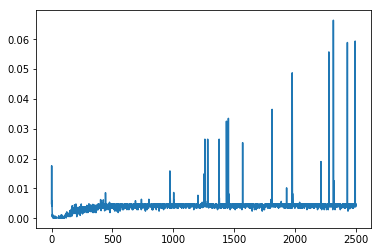

In [12]:
plt.plot(agent_k.loss_vec)

In [28]:
def dsr_feature_init(ref,**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 0.1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNet_backup(config.action_dim, SRIdentityBody(config.state_dim))
#     config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), \
#                         Phi2Psi(config.state_dim, config.action_dim, hidden_units=(104,)))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 3e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 1000
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 1e5
    config.async_actor = False
    
    agent = DSRAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    agent.network.load_state_dict(ref.network.state_dict())
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
        
    return agent

In [30]:
game = 'FourRooms'
agent_f = dsr_feature_init(ref=agent_k, game='FourRooms-Goal-9')

2020-04-02 21:45:50,456 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-04-02 21:46:06,209 - root - INFO: steps 5000, episodic_return_test -200.00(0.00)
2020-04-02 21:46:21,184 - root - INFO: steps 10000, episodic_return_test -200.00(0.00)
2020-04-02 21:46:36,176 - root - INFO: steps 15000, episodic_return_test -200.00(0.00)
2020-04-02 21:46:49,992 - root - INFO: steps 20000, episodic_return_test -180.30(18.69)
2020-04-02 21:47:06,490 - root - INFO: steps 25000, episodic_return_test -200.00(0.00)
2020-04-02 21:47:21,932 - root - INFO: steps 30000, episodic_return_test -200.00(0.00)
2020-04-02 21:47:36,349 - root - INFO: steps 35000, episodic_return_test -200.00(0.00)
2020-04-02 21:47:57,667 - root - INFO: steps 40000, episodic_return_test -200.00(0.00)
2020-04-02 21:48:22,671 - root - INFO: steps 45000, episodic_return_test -200.00(0.00)
2020-04-02 21:48:54,886 - root - INFO: steps 50000, episodic_return_test -200.00(0.00)
2020-04-02 21:49:23,702 - root - INFO: steps 55

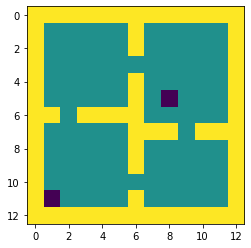

In [42]:
from deep_rl.component.fourrooms import FourRooms
env = FourRooms(goal=94)
state = env.reset()
plt.imshow(env.render())

In [66]:
psi[0][0][:]

array([0.00000000e+00, 7.92264342e-02, 7.96458572e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.11224514e-02,
       7.99650475e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.77617371e-02, 1.13094233e-01,
       2.80715585e-01, 2.06311405e-01, 0.00000000e+00, 1.64338574e-02,
       1.55588120e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.75018907e-01, 1.79930970e-01,
       5.07492572e-02, 2.90803183e-02, 0.00000000e+00, 4.61914539e-02,
       1.62871242e-01, 5.02007678e-02, 1.73333790e-02, 0.00000000e+00,
       1.95972830e-01, 1.03342738e-02, 0.00000000e+00, 7.58779496e-02,
       0.00000000e+00, 0.00000000e+00, 9.38741490e-02, 0.00000000e+00,
       1.78349108e-01, 0.00000000e+00, 1.24861002e-02, 0.00000000e+00,
       2.75954604e-04, 4.49515045e-01, 2.84563825e-02, 0.00000000e+00,
       0.00000000e+00, 7.98890069e-02, 4.33190167e-02, 0.00000000e+00,
      

(<matplotlib.image.AxesImage at 0x7f2515bd0748>,
 <matplotlib.colorbar.Colorbar at 0x7f2515b90198>)

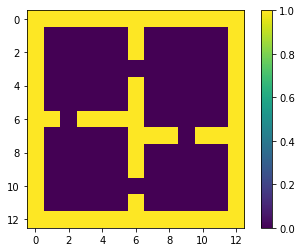

In [65]:
grid = np.array(env.occupancy)
for i in range(104):
    grid[env.tocell[i][0], env.tocell[i][1]] = psi[0][0][i]
plt.imshow(grid), plt.colorbar()

In [64]:
phi, psi, q = agent1.network(tensor(state).unsqueeze(0))
psi=psi.detach().numpy()
print(psi.shape)

(1, 4, 104)


### DQN agent class

In [2]:
class DQNActor(BaseActor):
    def __init__(self, config):
        BaseActor.__init__(self, config)
        self.config = config
        self.start()

    def _transition(self):
        if self._state is None:
            self._state = self._task.reset()
        config = self.config
        with config.lock:
            q_values = self._network(config.state_normalizer(self._state))
        q_values = to_np(q_values).flatten()
        if self._total_steps < config.exploration_steps \
                or np.random.rand() < config.random_action_prob():
            action = np.random.randint(0, len(q_values))
        else:
            action = np.argmax(q_values)
        next_state, reward, done, info = self._task.step([action])
        entry = [self._state[0], action, reward[0], next_state[0], int(done[0]), info]
        self._total_steps += 1
        self._state = next_state
        return entry


class DQNAgent(BaseAgent):
    def __init__(self, config):
        BaseAgent.__init__(self, config)
        self.config = config
        config.lock = mp.Lock()

        self.returns = []
        
        self.replay = config.replay_fn()
        self.actor = DQNActor(config)

        self.network = config.network_fn()
        self.network.share_memory()
        self.target_network = config.network_fn()
        self.target_network.load_state_dict(self.network.state_dict())
        self.optimizer = config.optimizer_fn(self.network.parameters())
        self.loss_vec = []

        self.actor.set_network(self.network)

        self.total_steps = 0
        self.batch_indices = range_tensor(self.replay.batch_size)

    def close(self):
        close_obj(self.replay)
        close_obj(self.actor)

    def eval_step(self, state):
        self.config.state_normalizer.set_read_only()
        state = self.config.state_normalizer(state)
        q = self.network(state)
        action = to_np(q.argmax(-1))
        self.config.state_normalizer.unset_read_only()
        return action

    def step(self):
        config = self.config
        transitions = self.actor.step()
        experiences = []
        for state, action, reward, next_state, done, info in transitions:
#             self.record_online_return(info)
            
            # Recording train returns in list
            for i, info_ in enumerate(info):
                ret = info_['episodic_return']
                if ret is not None:
                    self.returns.append([self.total_steps, ret])
            
            self.total_steps += 1
            reward = config.reward_normalizer(reward)
            experiences.append([state, action, reward, next_state, done])
        self.replay.feed_batch(experiences)

        if self.total_steps > self.config.exploration_steps:
            experiences = self.replay.sample()
            states, actions, rewards, next_states, terminals = experiences
            states = self.config.state_normalizer(states)
            next_states = self.config.state_normalizer(next_states)
            q_next = self.target_network(next_states).detach()
            if self.config.double_q:
                best_actions = torch.argmax(self.network(next_states), dim=-1)
                q_next = q_next[self.batch_indices, best_actions]
            else:
                q_next = q_next.max(1)[0]
            terminals = tensor(terminals)
            rewards = tensor(rewards)
            q_next = self.config.discount * q_next * (1 - terminals)
            q_next.add_(rewards)
            actions = tensor(actions).long()
            q = self.network(states)
            q = q[self.batch_indices, actions]
            loss = (q_next - q).pow(2).mul(0.5).mean()
            self.loss_vec.append(loss.item())
            self.optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(self.network.parameters(), self.config.gradient_clip)
            with config.lock:
                self.optimizer.step()

        if self.total_steps / self.config.sgd_update_frequency % \
                self.config.target_network_update_freq == 0:
            self.target_network.load_state_dict(self.network.state_dict())

### DSR agent class

In [2]:
class SRNet_backup(nn.Module):
    """
    Added by Surya.
    SR fully connected body network.
    """
    def __init__(self, output_dim, body, gate=F.relu):
        super(SRNet_backup, self).__init__()
        self.body = body
        self.output_dim = output_dim# TODO: check if this is the right way to do it
        self.layer1 = layer_init(nn.Linear(body.feature_dim, body.feature_dim))
        self.layer2 = layer_init(nn.Linear(body.feature_dim, body.feature_dim))
        self.layer3 = layer_init(nn.Linear(body.feature_dim, body.feature_dim * output_dim))
        self.gate = gate
        self.feature_dim = body.feature_dim * output_dim
        self.w = Parameter(torch.Tensor(body.feature_dim))

    def forward(self, x):
        phi = self.body(tensor(x)) # shape: b x state_dim
        psi = self.gate(self.layer1(phi)) # shape: b x state_dim
        psi = self.gate(self.layer2(psi)) # shape: b x (state_dim)
        psi = self.gate(self.layer3(psi)) # shape: b x (state_dim*action_dim)
        psi = psi.view(psi.size(0), self.output_dim, self.body.feature_dim) # shape: b x action_dim x state_dim
        out = torch.matmul(psi, self.w)

        return phi, psi, out

#######################################################################
# Copyright (C) 2017 Shangtong Zhang(zhangshangtong.cpp@gmail.com)    #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

"""
DQN code modified to convert it to DSR by Surya.
The representations are not learned in this network.

"""


class DSRActor(BaseActor):
    def __init__(self, config):
        BaseActor.__init__(self, config)
        self.config = config
        self.start()

    def _transition(self):
        if self._state is None:
            self._state = self._task.reset()
        config = self.config
        with config.lock:
            _, psi, q_values = self._network(config.state_normalizer(self._state))
        q_values = to_np(q_values).flatten()
        if self._total_steps < config.exploration_steps \
                or np.random.rand() < config.random_action_prob():
            action = np.random.randint(0, len(q_values))
        else:
            action = np.argmax(q_values)
        next_state, reward, done, info = self._task.step([action])
        
        entry = [self._state[0], action, reward[0], next_state[0], int(done[0]), info]
        self._total_steps += 1
        self._state = next_state
        return entry


class DSRAgent(BaseAgent):
    def __init__(self, config):
        BaseAgent.__init__(self, config)
        self.config = config
        config.lock = mp.Lock()
        
        self.loss_q_vec = []
        self.loss_psi_vec = []
        self.loss_vec = []
        self.returns = []

        self.replay = config.replay_fn()
        self.actor = DSRActor(config)

        self.network = config.network_fn()
        self.network.share_memory()
        self.target_network = config.network_fn()
        self.target_network.load_state_dict(self.network.state_dict())
        self.optimizer = config.optimizer_fn(self.network.parameters())

        self.actor.set_network(self.network)

        self.total_steps = 0
        self.batch_indices = range_tensor(self.replay.batch_size)

    def close(self):
        close_obj(self.replay)
        close_obj(self.actor)

    def eval_step(self, state):
        self.config.state_normalizer.set_read_only()
        state = self.config.state_normalizer(state)
        _, _, q = self.network(state)
        action = to_np(q.argmax(-1))
        self.config.state_normalizer.unset_read_only()
        return action

    def step(self):
        config = self.config

        # Store transitions in the buffer
        transitions = self.actor.step()
        experiences = []
        for state, action, reward, next_state, done, info in transitions:
#             self.record_online_return(info)
            
            
            # Recording train returns in list
            for i, info_ in enumerate(info):
                ret = info_['episodic_return']
                if ret is not None:
                    self.returns.append([self.total_steps, ret])
                    
            self.total_steps += 1
            reward = config.reward_normalizer(reward)
            experiences.append([state, action, reward, next_state, done])
        self.replay.feed_batch(experiences)

        # Start updating network parameters after exploration_steps
        if self.total_steps > self.config.exploration_steps:
#             import pdb; pdb.set_trace()
            experiences = self.replay.sample()
            states, actions, rewards, next_states, terminals = experiences
            states = self.config.state_normalizer(states)
            next_states = self.config.state_normalizer(next_states)

            # Computing targets
            _, psi_next, q_next = self.target_network(next_states)
            psi_next = psi_next.detach()
            q_next = q_next.detach()
            if self.config.double_q:
                best_actions = torch.argmax(self.network(next_states), dim=-1)
                q_next = q_next[self.batch_indices, best_actions]
            else:
                q_next = q_next.max(1)[0]
                psi_next = psi_next.max(1)[0] # TODO: double check dims here # CHECK

            terminals = tensor(terminals)
            rewards = tensor(rewards)
            q_next = self.config.discount * q_next * (1 - terminals)
            q_next.add_(rewards)
            psi_next = self.config.discount * psi_next * (1 - terminals.unsqueeze(1).repeat(1, psi_next.shape[1]))
            psi_next.add_(self.target_network(next_states)[0]) # TODO: double chec this

            # Computing estimates
            actions = tensor(actions).long()
            _, psi, q = self.network(states)
            q = q[self.batch_indices, actions]
            psi = psi[self.batch_indices, actions, :]

            # Estimating the loss
            loss_q = (q_next - q).pow(2).mul(0.5).mean()
            loss_psi = (psi_next - psi).pow(2).mul(0.5).mean()
            loss = loss_q + config.c * loss_psi
            
            self.loss_vec.append(loss.item())
            self.loss_q_vec.append(loss_q.item())
            self.loss_psi_vec.append(loss_psi.item())
            
            
            self.optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(self.network.parameters(), self.config.gradient_clip)

            with config.lock:
                self.optimizer.step()

        if self.total_steps / self.config.sgd_update_frequency % \
                self.config.target_network_update_freq == 0:
            self.target_network.load_state_dict(self.network.state_dict())

### Code: DSR

In [3]:
def dsr_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 0.1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNet_backup(config.action_dim, SRIdentityBody(config.state_dim))
#     config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), \
#                         Phi2Psi(config.state_dim, config.action_dim, hidden_units=(104,)))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 3e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 1000
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 1e5
    config.async_actor = False
    
    agent = DSRAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
        
    return agent
    
# DQN
def dqn_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 1e4)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 1000
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 5e4
    config.async_actor = False
    agent = DQNAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
    return agent

In [4]:
mkdir('log')
mkdir('tf_log')
set_one_thread()
random_seed()
select_device(-1)

In [ ]:
game = 'FourRooms'
agent1 = dsr_feature(game='FourRooms-Goal-9')

2020-04-02 22:04:15,460 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-04-02 22:04:26,694 - root - INFO: steps 5000, episodic_return_test -124.80(29.22)
2020-04-02 22:04:40,236 - root - INFO: steps 10000, episodic_return_test -200.00(0.00)
2020-04-02 22:04:54,994 - root - INFO: steps 15000, episodic_return_test -200.00(0.00)
2020-04-02 22:05:09,666 - root - INFO: steps 20000, episodic_return_test -200.00(0.00)
2020-04-02 22:05:26,444 - root - INFO: steps 25000, episodic_return_test -200.00(0.00)
2020-04-02 22:05:43,629 - root - INFO: steps 30000, episodic_return_test -200.00(0.00)
2020-04-02 22:06:00,596 - root - INFO: steps 35000, episodic_return_test -200.00(0.00)
2020-04-02 22:06:18,978 - root - INFO: steps 40000, episodic_return_test -200.00(0.00)
2020-04-02 22:06:48,765 - root - INFO: steps 45000, episodic_return_test -157.90(21.73)
2020-04-02 22:07:06,685 - root - INFO: steps 50000, episodic_return_test -200.00(0.00)
2020-04-02 22:07:24,870 - root - INFO: steps 5

(621, 2)


Text(0.5,1,'DSR training performance 4rooms')

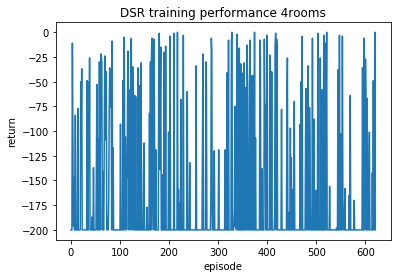

In [31]:
# print(agent1.returns)
returns = np.array(agent1.returns)
print(returns.shape) # 1e5 x 2
plt.plot(returns[:,1])
plt.xlabel('episode'), plt.ylabel('return')
plt.title('DSR training performance 4rooms')

In [ ]:
agent1.network(tensor(state).unsqueeze(0))

In [7]:
agent2 = dsr_feature(game='FourRooms-Goal-0')

2020-04-02 21:21:58,144 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-04-02 21:22:05,455 - root - INFO: steps 5000, episodic_return_test -200.00(0.00)
2020-04-02 21:22:14,028 - root - INFO: steps 10000, episodic_return_test -200.00(0.00)
2020-04-02 21:22:22,141 - root - INFO: steps 15000, episodic_return_test -200.00(0.00)
2020-04-02 21:22:30,021 - root - INFO: steps 20000, episodic_return_test -200.00(0.00)
2020-04-02 21:22:37,704 - root - INFO: steps 25000, episodic_return_test -200.00(0.00)
2020-04-02 21:22:45,485 - root - INFO: steps 30000, episodic_return_test -200.00(0.00)
2020-04-02 21:22:53,227 - root - INFO: steps 35000, episodic_return_test -200.00(0.00)
2020-04-02 21:23:00,845 - root - INFO: steps 40000, episodic_return_test -200.00(0.00)
2020-04-02 21:23:08,704 - root - INFO: steps 45000, episodic_return_test -180.00(18.97)
2020-04-02 21:23:16,453 - root - INFO: steps 50000, episodic_return_test -180.20(18.78)
2020-04-02 21:23:24,156 - root - INFO: steps 5

In [8]:
agent3 = dsr_feature(game='FourRooms-Goal-94')

2020-04-02 21:24:36,563 - root - INFO: steps 0, episodic_return_test -160.20(25.17)
2020-04-02 21:24:43,673 - root - INFO: steps 5000, episodic_return_test -200.00(0.00)
2020-04-02 21:24:51,553 - root - INFO: steps 10000, episodic_return_test -200.00(0.00)
2020-04-02 21:24:59,482 - root - INFO: steps 15000, episodic_return_test -200.00(0.00)
2020-04-02 21:25:07,294 - root - INFO: steps 20000, episodic_return_test -200.00(0.00)
2020-04-02 21:25:15,227 - root - INFO: steps 25000, episodic_return_test -200.00(0.00)
2020-04-02 21:25:23,914 - root - INFO: steps 30000, episodic_return_test -200.00(0.00)
2020-04-02 21:25:31,811 - root - INFO: steps 35000, episodic_return_test -200.00(0.00)
2020-04-02 21:25:39,696 - root - INFO: steps 40000, episodic_return_test -200.00(0.00)
2020-04-02 21:25:47,625 - root - INFO: steps 45000, episodic_return_test -200.00(0.00)
2020-04-02 21:25:55,745 - root - INFO: steps 50000, episodic_return_test -200.00(0.00)
2020-04-02 21:26:03,847 - root - INFO: steps 55

In [15]:
game = 'FourRooms-Goal-94'
agent = dqn_feature(game=game)

2020-04-01 17:58:24,446 - root - INFO: steps 0, episodic_return_test -200.00(0.00)
2020-04-01 17:58:29,323 - root - INFO: steps 5000, episodic_return_test -180.80(18.21)
2020-04-01 17:58:34,733 - root - INFO: steps 10000, episodic_return_test -161.00(24.67)
2020-04-01 17:58:39,975 - root - INFO: steps 15000, episodic_return_test -141.60(28.21)
2020-04-01 17:58:45,140 - root - INFO: steps 20000, episodic_return_test -126.00(28.70)
2020-04-01 17:58:50,219 - root - INFO: steps 25000, episodic_return_test -50.90(23.64)
2020-04-01 17:58:55,500 - root - INFO: steps 30000, episodic_return_test -47.10(24.26)
2020-04-01 17:59:00,769 - root - INFO: steps 35000, episodic_return_test -14.70(1.78)
2020-04-01 17:59:05,947 - root - INFO: steps 40000, episodic_return_test -14.80(2.34)
2020-04-01 17:59:11,154 - root - INFO: steps 45000, episodic_return_test -13.00(2.07)
2020-04-01 17:59:16,589 - root - INFO: steps 50000, episodic_return_test -89.10(28.71)


In [27]:
def smooth_curve(points, factor=0.75):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

def convolve(points, kernelSize=5):
    array = np.convolve(points, np.ones(kernelSize), 'valid')
    return array

Text(0.5, 1.0, 'DQN training performance 4rooms')

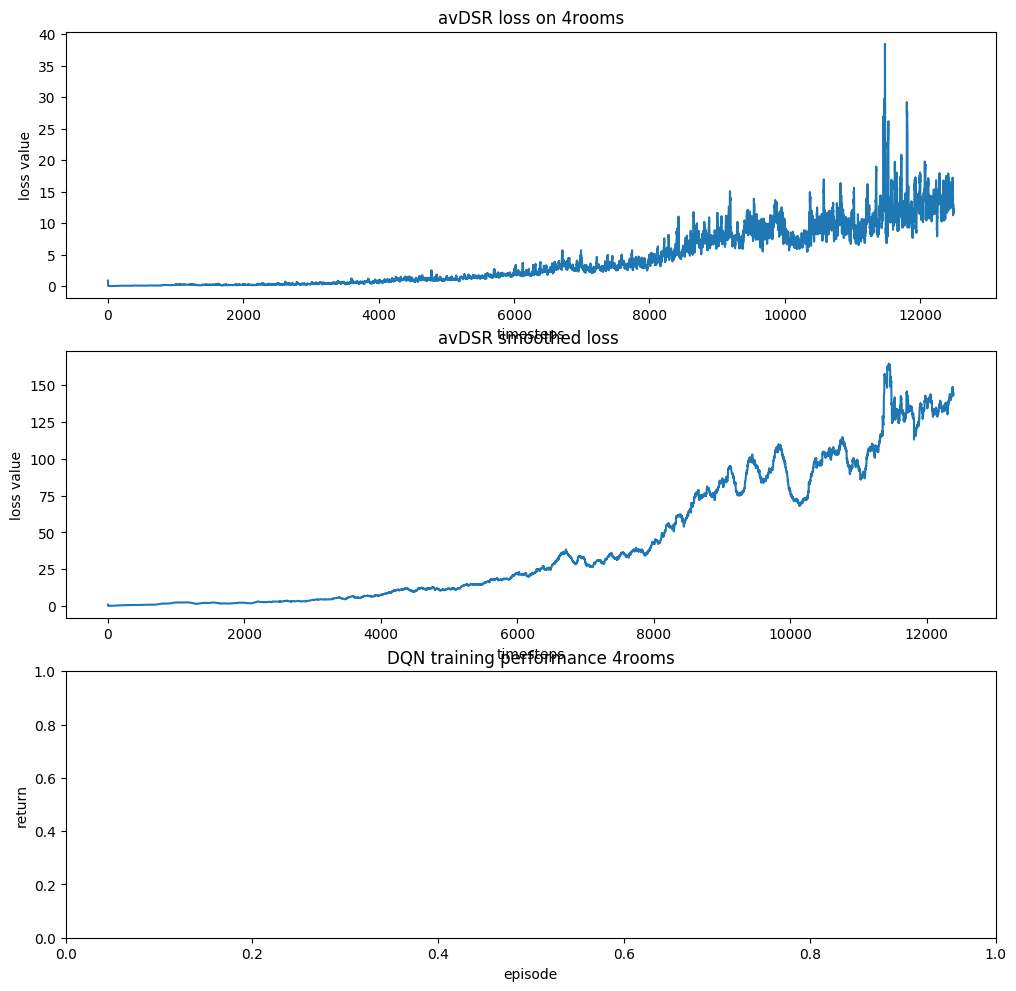

In [41]:
title = 'avDSR'
plt.figure(figsize=(12,12),dpi=100)
plt.subplot(311)
plt.plot(convolve(agent0.loss_vec, kernelSize=11))
plt.title(title+' loss on 4rooms')
plt.ylabel('loss value'), plt.xlabel('timesteps')
plt.subplot(312)
plt.plot(convolve(agent0.loss_vec, kernelSize=111))
plt.title(title+' smoothed loss ')
plt.ylabel('loss value'), plt.xlabel('timesteps')
plt.subplot(313)
# plt.plot(returns[:,1])
plt.xlabel('episode'), plt.ylabel('return')
plt.title('DQN training performance 4rooms')

# return
# plt.plot(smooth_curve(agent1.loss_q_vec, factor=0.0))

# plt.figure(figsize=(18,6),dpi=100)
# plt.plot(smooth_curve(agent1.loss_psi_vec, factor=0.0))
# plt.plot(agent.loss_vec)

In [25]:
agent.network(tensor(state).unsqueeze(0))

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[[20.1890, 11.1481,  7.7122,  6.8928,  8.7038,  0.0000,  3.4228,
            0.0000,  3.0503,  2.2156, 21.1240, 10.8059,  4.7677,  0.0000,
            4.5388,  0.0000,  2.3827,  0.0000,  3.5569,  4.4280, 20.2903,
           10.1940,  5.6592,  4.8325,  4.2503, 13.4283,  4.5743,  2.8576,
            2.6492,  0.0000, 28.9855,  0.0000, 10.2233,  7.1185,  0.0000,
            9.8279,  5.7012,  0.0000,  7.3507, 11.6228, 28.7064, 23.8152,
           11.6036, 10.5501, 14.5004, 11.3163, 15.9335,  9.4233, 13.5610,
   

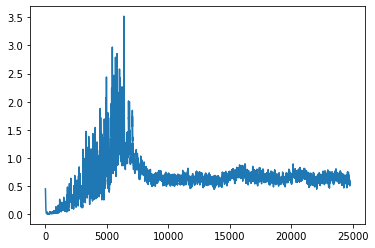

In [26]:
plt.plot(smooth_curve(agent.loss_vec, factor=0.95))
# plt.plot(agent.loss_vec)

In [ ]:
dqn_feature(game=game)

In [12]:
import re
%ls log/

CartPole-v0--run-0-200227-205236.txt  FourRooms--run-0-200302-131223.txt
CartPole-v0--run-0-200228-004756.txt  FourRooms--run-0-200302-133932.txt
CartPole-v0--run-0-200301-163526.txt  FourRooms--run-0-200302-142141.txt
CartPole-v0--run-0-200301-164329.txt  FourRooms--run-0-200302-142221.txt
CartPole-v0--run-0-200301-164446.txt  FourRooms--run-0-200302-142245.txt
CartPole-v0--run-0-200302-132052.txt  FourRooms--run-0-200302-142327.txt
FourRooms--run-0-200228-000646.txt    FourRooms--run-0-200302-142437.txt
FourRooms--run-0-200228-005249.txt    FourRooms--run-0-200302-142749.txt
FourRooms--run-0-200228-005912.txt    FourRooms--run-0-200302-143321.txt
FourRooms--run-0-200228-010316.txt    FourRooms--run-0-200302-143657.txt
FourRooms--run-0-200228-010531.txt    FourRooms--run-0-200302-155036.txt
FourRooms--run-0-200228-011410.txt    FourRooms--run-0-200302-155114.txt
FourRooms--run-0-200228-012330.txt    FourRooms--run-0-200302-155259.txt
FourRooms--run-0-200228-012412.txt    FourRooms--ru

In [13]:
def log2list(filename):
    returns_train = []
    returns_test = []
    with open(filename, 'rb') as f:
        while True:
            line = f.readline()
            split = re.split('\s', str(line))
            if not line:
                break
            if('episodic_return_train' in split):
                returns_train.append(float(split[-1][:-3]))
            if('episodic_return_test' in split):
                returns_test.append(float(split[-1][:-10]))
                
    return returns_train, returns_test

In [14]:
dsr_file = 'log/FourRooms--run-0-200308-160832.txt'
# dqn_file = 'log/FourRooms--run-0-200301-161113.txt'

In [15]:
train_dsr, test_dsr = log2list(dsr_file)
# train_dqn, test_dqn = log2list(dqn_file)
# train_max = min(len(train_dsr), len(train_dqn))
# test_max = min(len(test_dsr), len(test_dqn))

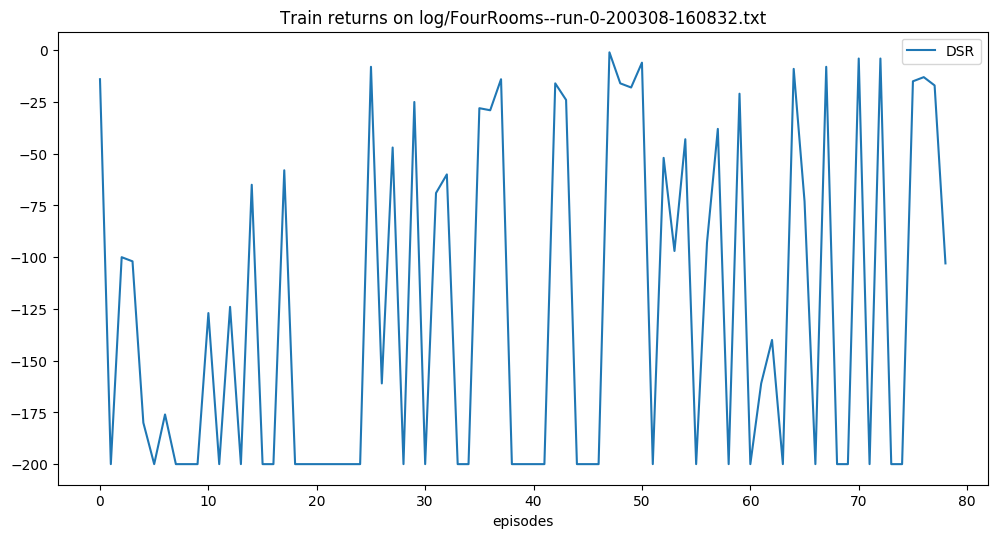

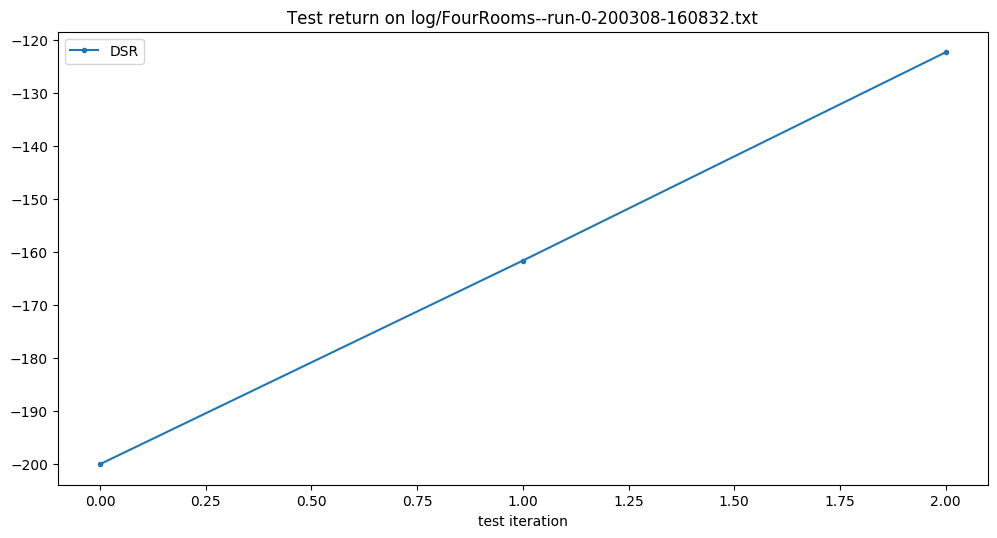

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6), dpi=100)
# plt.plot(train_dqn[:train_max], label='DQN')
plt.plot(train_dsr[:], label='DSR')
plt.title('Train returns on ' + dsr_file)
plt.xlabel('episodes'), plt.legend()
plt.show()

plt.figure(figsize=(12,6), dpi=100)
# plt.plot(test_dqn[:test_max], '.-', label='DQN')
plt.plot(test_dsr[:], '.-', label='DSR')
plt.title('Test return on ' + dsr_file)
plt.xlabel('test iteration'), plt.legend()
plt.show()